# Deep GP samples

To help develop a more intuitive understanding of deep Gaussian processes, in this notebook we show how to generate a sample from the full deep GP, by propagating a sample through the layers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import gpflow
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer

tf.random.set_seed(42)

2022-04-06 13:23:47.305720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:23:47.305756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_data = 200
D = 1
a, b = 0, 1
X = np.linspace(a, b, num_data).reshape(-1, 1)

## Constructing the layers

Note that we give the `full_cov=True` argument to `GPLayer` so that we obtain correlated samples.
We give the last layer a `gpflow.mean_functions.Zero` mean function (the GPflux default is an Identity mean function).

In [3]:
num_samples = 5

In [4]:
Z = X.copy()
M = Z.shape[0]

# Layer 1
inducing_var1 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel1 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.15),
    output_dim=D,
    share_hyperparams=True,
)
layer1 = GPLayer(kernel1, inducing_var1, num_data, full_cov=True, num_samples=num_samples)

# Layer 2
inducing_var2 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel2 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.8, variance=0.1),
    output_dim=D,
    share_hyperparams=True,
)
layer2 = GPLayer(kernel2, inducing_var2, num_data, full_cov=True, num_samples=num_samples)

# Layer 3
inducing_var3 = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
kernel3 = construct_basic_kernel(
    gpflow.kernels.SquaredExponential(lengthscales=0.3, variance=0.1),
    output_dim=D,
    share_hyperparams=True,
)
layer3 = GPLayer(
    kernel3,
    inducing_var3,
    num_data,
    full_cov=True,
    num_samples=num_samples,
    mean_function=gpflow.mean_functions.Zero(),
)

gp_layers = [layer1, layer2, layer3]

2022-04-06 13:23:48.928073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:23:48.928104: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 13:23:48.928129: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az121-341): /proc/driver/nvidia/version does not exist
2022-04-06 13:23:48.928430: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/runner/work/GPflux/GPflux/gpflux/la

## Propagating samples through the layers

In [5]:
layer_input = X

In [6]:
means, covs, samples = [], [], []

for layer in gp_layers:
    layer_output = layer(layer_input)

    mean = layer_output.mean()
    cov = layer_output.covariance()
    sample = tf.convert_to_tensor(layer_output)  # generates num_samples samples...

    layer_input = sample[0]  # for the next layer

    means.append(mean.numpy().T)  # transpose to go from [1, N] to [N, 1]
    covs.append(cov.numpy())
    samples.append(sample.numpy())

2022-04-06 13:23:49.170330: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Visualising samples

From top to bottom we plot the input to a layer, the covariance of outputs of that layer, and samples from the layer's output.

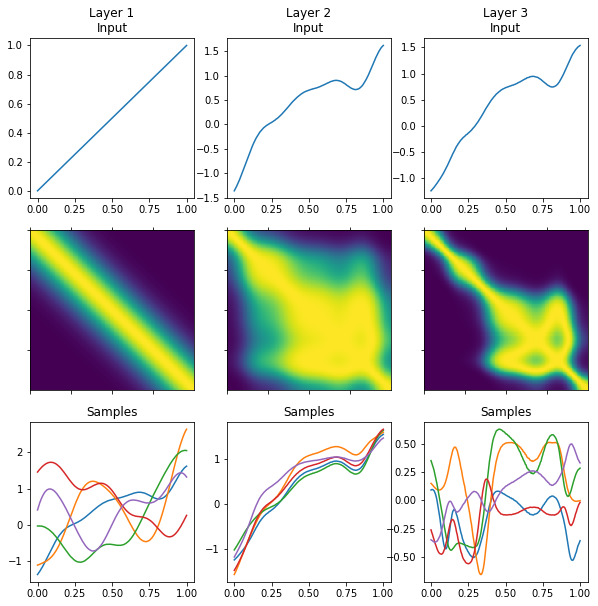

In [7]:
num_layers = len(gp_layers)
fig, axes = plt.subplots(3, num_layers, figsize=(num_layers * 3.33, 10))

for i in range(num_layers):
    layer_input = X if i == 0 else samples[i - 1][0]
    plot_layer(X, layer_input, means[i], covs[i], samples[i], i, axes[:, i])